## IMA205 challenge 
goal detect skin legions

1. Data Collection:

we have the given data 
todo :\
[] explore the data \
[] understand the data \
[] visualize the data \
[] clean the data \
[] preprocess the data



#### 1.1 Data exploration 
we have the following data : 
- a train set of images : 18998
- a test set of images : 6333
- a csv file with the labels of the train set 
- a csv file with the labels of the test set
### Metadata Files:

#### metadataTrain.csv
Contains metadata information and class labels for all training images.

**Columns:**
- **ID**: Unique identifier for each image (e.g., ISIC_0055289).
- **CLASS**: Class label of the image (integer between 1 and 8).
- **Age**: Age of the patient, when available.
- **Sex**: Gender of the patient, when available.
- **Anatomical Location**: Location of the lesion on the body, when available.

#### metadataTest.csv
Contains metadata information for all test images.

**Columns:**
- **ID**: Unique identifier for each image (e.g., ISIC_0055289).
- **Age**: Age of the patient, when available.
- **Sex**: Gender of the patient, when available.
- **Anatomical Location**: Location of the lesion on the body, when available.


In [10]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# Load metadata files
train_metadata = pd.read_csv('metadataTrain.csv')
test_metadata = pd.read_csv('metadataTest.csv')

# Display first few rows of the training metadata
print("Training Metadata:")
print(train_metadata.head())

# Display first few rows of the test metadata
print("\nTest Metadata:")
print(test_metadata.head())

# Summary statistics 
print("\nTraining Metadata Summary:")
print(train_metadata.describe(include='all'))

print("\nTest Metadata Summary:")
print(test_metadata.describe(include='all'))


Training Metadata:
             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity

Test Metadata:
             ID     SEX   AGE         POSITION
0  ISIC_0055289  female  50.0  lower extremity
1  ISIC_0062682    male  65.0  lower extremity
2  ISIC_0057706  female  75.0              NaN
3  ISIC_0031702    male  70.0        head/neck
4  ISIC_0069272    male  60.0  lower extremity

Training Metadata Summary:
                  ID         CLASS    SEX           AGE        POSITION
count          18998  18998.000000  18714  18674.000000           17028
unique         18998           NaN      2           NaN               8
top     ISIC_0028766           NaN   male           NaN  anterior torso
freq               1           NaN   9978  

### 1.2 Data Preprocessing

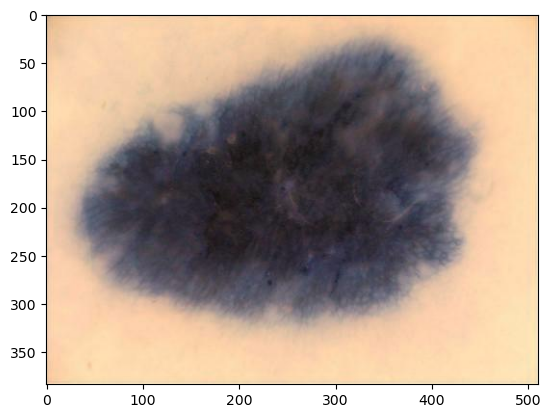

In [11]:
# display an image using cv2 from the folder train/trian 

# Load an image using OpenCV
img = cv2.imread('train/train/ISIC_0000000.jpg')

# Display image
plt.imshow(img)


In [15]:
import cv2
import os
import numpy as np

# Function to load and preprocess images
def load_and_preprocess_images(folder_path, metadata):
    images = []
    masks = []
    labels = []
    
    for index, row in metadata.iterrows():
        image_id = row['ID']
        print("image_id: ", image_id)
        class_label = row['CLASS']
        
        # Load image
        try : 
            image_path = os.path.join(folder_path, f"{image_id}.jpg")
        catch :
            print("error in loading image")
        
        image = cv2.imread(image_path)
        print("image shape: ", image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Load segmentation mask (if available)
        mask_path = os.path.join(folder_path, "Segmentations", f"{image_id}_segmentation.png")
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            masks.append(mask)
        
        images.append(image)
        labels.append(class_label)
    
    return np.array(images), np.array(masks), np.array(labels)

# Preprocess training images and masks
train_images, train_masks, train_labels = load_and_preprocess_images("train/train", train_metadata)

# Preprocess test images
test_images, _, _ = load_and_preprocess_images("Test", test_metadata)

# Normalize images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Display shapes
print("\nTraining Images Shape:", train_images.shape)
print("Training Masks Shape:", train_masks.shape)
print("Training Labels Shape:", train_labels.shape)
print("\nTest Images Shape:", test_images.shape)


image_id:  ISIC_0028766
image_id:  ISIC_0071222


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



## 2. Feature Extraction:

After obtaining the dataset, we'll extract features from the images. The features we are interested in are:

Asymmetry: A measure of how symmetric the lesion is.
Border Irregularity: Describes the irregularity of the lesion's border.
Colour: Different color variations within the lesion.
Dimension: Size and shape of the lesion.

Feature Extraction Methods:

Asymmetry: Calculate the asymmetry by comparing the lesion's halves. A perfectly symmetrical lesion would have a symmetry score close to 1.
Border Irregularity: This can be quantified by measuring the smoothness of the lesion's border. A more irregular border would have a higher irregularity score.
Colour: Extract color histograms or use color channels to analyze the variation in colors within the lesion.
Dimension: Calculate the size (area, perimeter) and shape (aspect ratio, circularity) of the lesion.


## 3. Machine Learning Classification:

Once we have the features extracted, we can use machine learning algorithms to classify the images into the eight diagnostic classes. Some popular algorithms for image classification are:

    Support Vector Machine (SVM)
    Random Forest
    Convolutional Neural Networks (CNN)

Steps for Classification:

Data Preprocessing: Normalize and standardize the extracted features.
Feature Selection: Select the most relevant features using techniques like feature importance or feature selection algorithms.
Model Training: Train the chosen machine learning algorithm on the preprocessed and selected features.
Model Evaluation: Evaluate the model using metrics like accuracy, precision, recall, and F1-score on a separate test set.
Hyperparameter Tuning: Optimize the model's hyperparameters to improve performance.



## 4. Model Deployment:

Once the model is trained and evaluated, it can be deployed as an AI solution for skin lesion classification. This can be done as a web application, mobile app, or integrated into existing healthcare systems.
Tools and Libraries:

    Python: For data preprocessing, feature extraction, and machine learning.
    Scikit-learn: For machine learning algorithms and feature extraction.
    OpenCV: For image processing and feature extraction.
    TensorFlow/Keras: For building and training neural networks if CNNs are used.